In [1]:
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
import numba
from numba import njit
from simulation_utils.utils import summarize_data_sets

from simulation_utils.preference import generate_ibp_nbp, generate_ibp 
from simulation_utils.preference import _draw_nnew_ibp_nbp, _draw_poisson_rvs_nbp, _draw_poisson_rvs

%matplotlib inline

In [2]:
nusers = 1000
nitems = 2000

In [3]:
res_list = []
for i in range(nitems):
    unif = uniform.rvs(size=nusers)
    popularity = 0
    popularity = np.sum(np.random.binomial(1, unif))
    res_list.append(popularity)

In [4]:
sorted_res = sorted(res_list, reverse=True)

In [5]:
item_popularity = pd.DataFrame.from_records(list(zip(range(1, nitems+1), sorted_res)), columns=['rank', 'popularity'])

In [6]:
item_popularity.head()

,rank,popularity
0,1,563
1,2,548
2,3,547
3,4,545
4,5,543


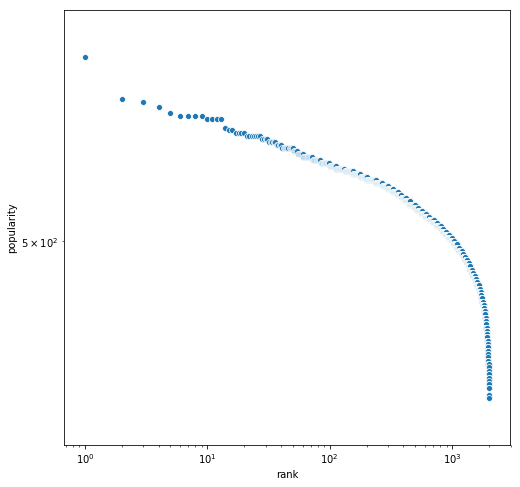

In [7]:
f, ax = plt.subplots(figsize=(8, 8))
ax.set(xscale='log', yscale='log')
sns.scatterplot(x='rank', y='popularity', data=item_popularity)

In [8]:
pop_count = item_popularity.groupby('popularity', as_index=False).count().rename(columns={'rank': 'count'})

In [9]:
pop_count.head()

,popularity,count
0,452,1
1,453,2
2,455,3
3,456,2
4,457,1


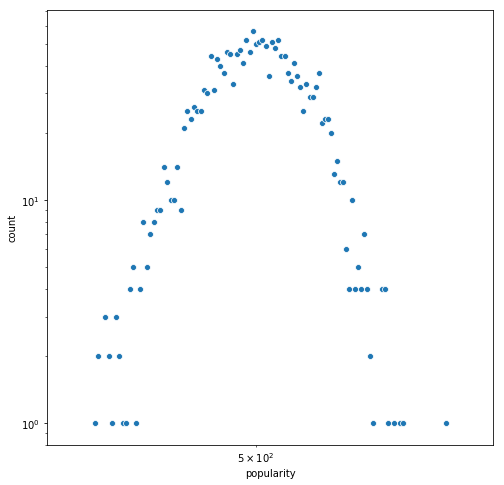

In [10]:
f, ax = plt.subplots(figsize=(8, 8))
ax.set(xscale='log', yscale='log')
sns.scatterplot(x='popularity', y='count', data=pop_count)

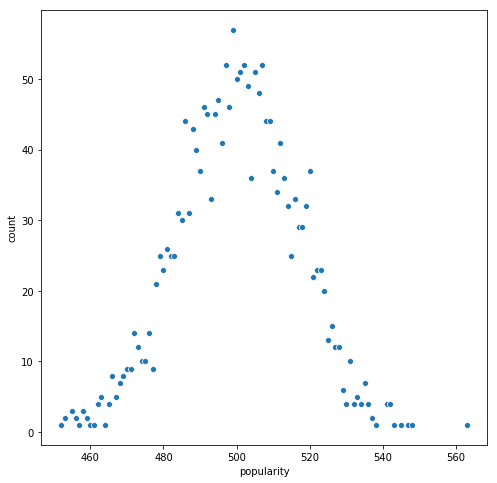

In [11]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='popularity', y='count', data=pop_count)

### Read real data

In [14]:
ml_100k = pd.read_csv('data/ml-100k/u.data', names=['user', 'item', 'rating', 'timestamp'], sep='\t')

In [15]:
ml_100k.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [16]:
item_popularity = ml_100k.groupby('item')['user'].count().reset_index()

In [17]:
item_popularity.head()

,item,user
0,1,452
1,2,131
2,3,90
3,4,209
4,5,86


In [19]:
pop_count = item_popularity.groupby('user', as_index=False).count().rename(columns={'item': 'count', 'user': 'popularity'})

In [20]:
pop_count.head()

,popularity,count
0,1,141
1,2,68
2,3,60
3,4,64
4,5,51


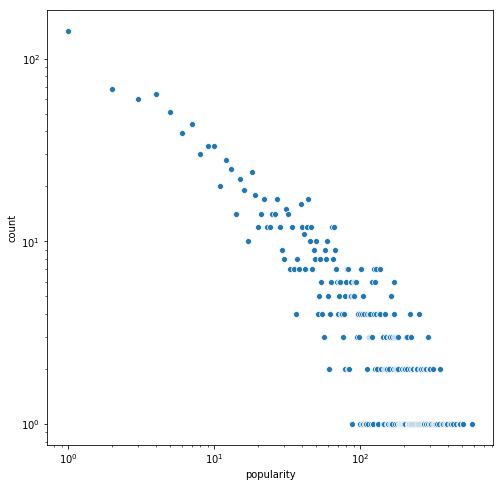

In [22]:
f, ax = plt.subplots(figsize=(8, 8))
ax.set(xscale='log', yscale='log')
sns.scatterplot(x='popularity', y='count', data=pop_count)

In [25]:
user_activity = ml_100k.groupby('user')['item'].count().reset_index().rename(columns={'item': 'activity'})

In [26]:
user_activity.head()

,user,activity
0,1,272
1,2,62
2,3,54
3,4,24
4,5,175


In [27]:
activity_count = user_activity.groupby('activity', as_index=False).count().rename(columns={'user': 'count'})

In [28]:
activity_count.head()

,activity,count
0,20,32
1,21,24
2,22,23
3,23,21
4,24,21


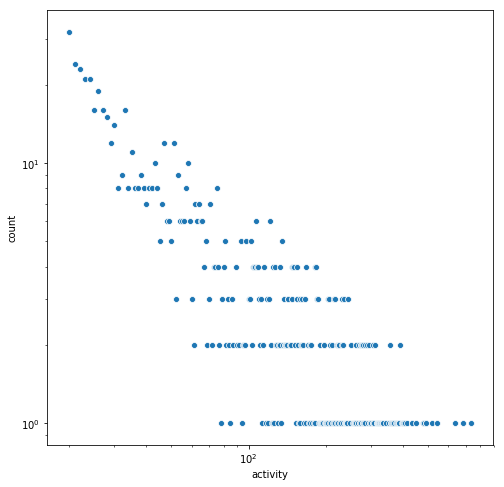

In [29]:
f, ax = plt.subplots(figsize=(8, 8))
ax.set(xscale='log', yscale='log')
sns.scatterplot(x='activity', y='count', data=activity_count)

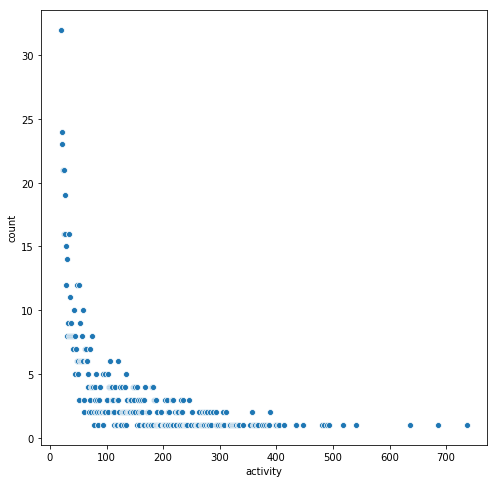

In [30]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='activity', y='count', data=activity_count)

Real dataset: both user activity and item popularity have power-law properties.

In [2]:
data = np.random.negative_binomial(1, 0.2, 1000)

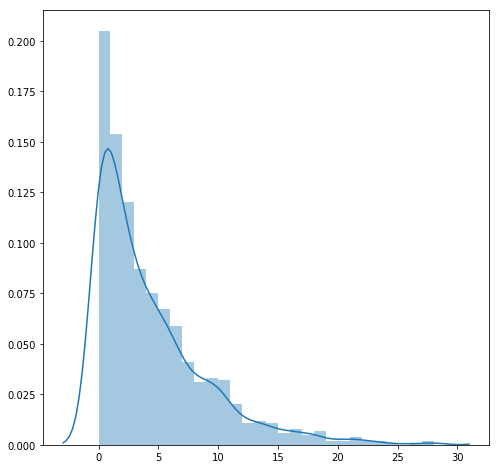

In [17]:
f, ax = plt.subplots(figsize=(8, 8))
sns.distplot(data)

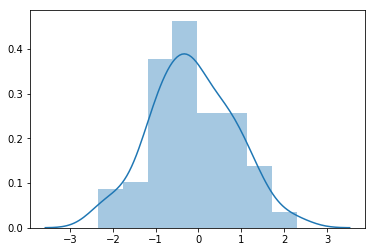

In [15]:
x = np.random.randn(100)
ax = sns.distplot(x)

### Beta-binomial distribution

In [35]:
def beta_binomial(a, b, n, size=None):
    p = np.random.beta(a, b, size)
    samples = np.random.binomial(n, p)
    return samples

In [84]:
a = 0.7
b = 2
n = 10
size = 10000

In [85]:
data = beta_binomail(a, b, n, size)

In [86]:
data.shape

(10000,)

In [87]:
from collections import Counter

counter = Counter(data)

In [88]:
df = pd.DataFrame.from_records(list(counter.items()), 
                          columns=['n', 'count'])
df['density'] = df['count'] / df['count'].sum()

In [ ]:
plt.plot('n', 'density', 'o', data=df)

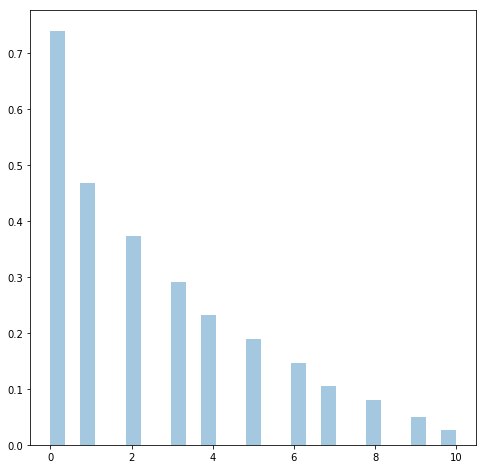

In [91]:
f, ax = plt.subplots(figsize=(8, 8))
sns.distplot(data, kde=False, norm_hist=True)

In [5]:
@njit
def sample_users(nusers, u_start, c=1, sigma=0):
    # the number of users who tried for each item (m_k)
    npicks = 1
    users = [u_start - 1]
    for u in range(u_start, nusers + 1):
        prob = (npicks - sigma) / (u - 1 + c)
        pick = np.random.binomial(np.int(1), prob) > 0
        if pick:
            users.append(u)
            npicks += 1
    return users

In [6]:
def generate_ibp_columnwise(nusers, alpha, c=1.0, sigma=0.0):
    nnew, _, _ = _draw_nnew_ibp_nbp(nusers, alpha, c, sigma)
    u_starts = np.repeat(np.arange(2, nusers + 2), nnew)
    users = []
    for i in u_starts:
        item_users = sample_users(nusers, i, c, sigma)
        users.append(item_users)
    return users

In [7]:
def records2frame(data, id_label='user', label='item'):
    nids = len(data)
    nrecords = [len(d) for d in data]
    ids = np.repeat(np.arange(nids), nrecords)
    records = np.hstack(data)
    return pd.DataFrame({id_label: ids, label: records})

In [21]:
def generate_uids(nusers, alpha, c=1.0, sigma=0.0):
    nnew = _draw_poisson_rvs(nusers, alpha, c, sigma)
    u_starts = np.repeat(np.arange(nusers), nnew)
    return u_starts

In [3]:
@njit
def generate_uids_nbp(nusers, alpha, c=1.0, sigma=0.0):
    nnew, start, end = _draw_nnew_ibp_nbp(nusers, alpha, c, sigma)
    nitems = end[-1]
    u_starts = np.empty(nitems, dtype=np.int64)
    for u in numba.prange(nusers):
        u_nnew = nnew[u]
        if u_nnew > 0:
            st = start[u]
            sp = end[u]
            u_starts[st:sp] = np.full(u_nnew, u)
    return u_starts

In [5]:
@njit(parallel=True)
def repeat_nbp(arr, repeats):
    end = np.cumsum(repeats)
    start = end - repeats
    nout = end[-1]
    out = np.empty(nout, dtype=np.int64)
    narr = len(arr)
    for i in numba.prange(narr):
        repeat = repeats[i]
        value = arr[i]
        if repeat > 0:
            st = start[i]
            sp = end[i]
            out[st:sp] = np.full(repeat, value)
    return out

In [18]:
@njit
def repeat_nb(arr, repeats):
    out = [np.int64(x) for x in range(0)]
    narr = len(arr)
    for i in range(narr):
        repeat = repeats[i]
        value = arr[i]
        out.extend([value] * repeat)
    return out

In [19]:
nusers = 10000
alpha = 20000* 0.6
c = 1
sigma = 0

In [20]:
nnew = _draw_poisson_rvs(nusers, alpha, c, sigma)

In [21]:
assert np.array_equal(np.repeat(np.arange(nusers), nnew), repeat_nb(np.arange(nusers), nnew))

In [22]:
%timeit np.repeat(np.arange(nusers), nnew)
%timeit repeat_nb(np.arange(nusers), nnew)
%timeit repeat_nbp(np.arange(nusers), nnew)

525 µs ± 10 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
5.79 ms ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.37 ms ± 9.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
%timeit generate_uids(nusers, alpha, c, sigma)
%timeit generate_uids_nbp(nusers, alpha, c, sigma)

12.1 ms ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.6 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%prun -l 10 generate_uids(nusers, alpha, c, sigma)

         24 function calls in 0.046 seconds

   Ordered by: internal time
   List reduced from 18 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.019    0.019    0.019    0.019 {method 'poisson' of 'mtrand.RandomState' objects}
        1    0.013    0.013    0.013    0.013 {method 'repeat' of 'numpy.ndarray' objects}
        1    0.012    0.012    0.032    0.032 preference.py:189(_draw_poisson_rvs)
        2    0.001    0.000    0.001    0.000 {built-in method numpy.core.multiarray.arange}
        1    0.000    0.000    0.046    0.046 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.000    0.000    0.000    0.000 fromnumeric.py:64(_wrapreduction)
        1    0.000    0.000    0.045    0.045 <ipython-input-21-0a926a5aaad8>:1(generate_uids)
        1    0.000    0.000    0.013    0.013 fromnumeric.py:49(_wrapfunc)
        2    0.000

In [33]:
%prun -l 10 generate_uids_nbp(nusers, alpha, c, sigma)

         4 function calls in 0.030 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.029    0.029    0.029    0.029 <ipython-input-29-25242db7ef04>:1(generate_uids_nbp)
        1    0.000    0.000    0.030    0.030 {built-in method builtins.exec}
        1    0.000    0.000    0.029    0.029 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [14]:
nusers = 10000
alpha = 2000* 0.6
c = 1
sigma = 0

In [9]:
def ibp_nbp():
    pref = generate_ibp_nbp(nusers, alpha, c, sigma)
    return records2frame(pref)

In [10]:
def ibp():
    return generate_ibp(nusers, alpha, c, sigma)

In [11]:
def ibp_colwise():
    pref = generate_ibp_itemwise(nusers, alpha, c, sigma)
    df = records2frame(pref, 'item', 'user')
    return records2frame(pref, 'item', 'user').reindex(columns=['user', 'item'])

dataset stats
       dataset  nusers  nitems    npairs   density
0          ibp   10000   11820  12354092  0.104519
1      ibp_nbp   10000   11773  12029791  0.102181
2  ibp_colwise   10000   11808  11997865  0.101608
user profile stats
              ibp       ibp_nbp   ibp_colwise
count  10000.0000  10000.000000  10000.000000
mean    1235.4092   1202.979100   1199.786500
std       24.6452     24.520142     24.785313
min     1146.0000   1120.000000   1096.000000
25%     1219.0000   1187.000000   1183.000000
50%     1235.0000   1203.000000   1200.000000
75%     1252.0000   1219.000000   1216.000000
max     1330.0000   1288.000000   1292.000000
item popularity stats
                ibp       ibp_nbp   ibp_colwise
count  11820.000000  11773.000000  11808.000000
mean    1045.185448   1021.811858   1016.079353
std     2054.125082   2020.979663   1996.341932
min        1.000000      1.000000      1.000000
25%        7.000000      7.000000      7.000000
50%       74.000000     76.000000     7

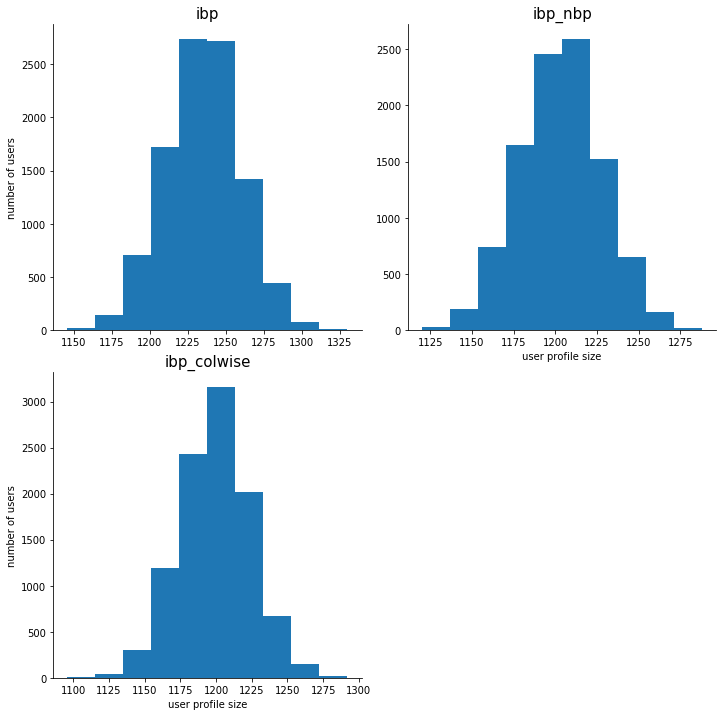

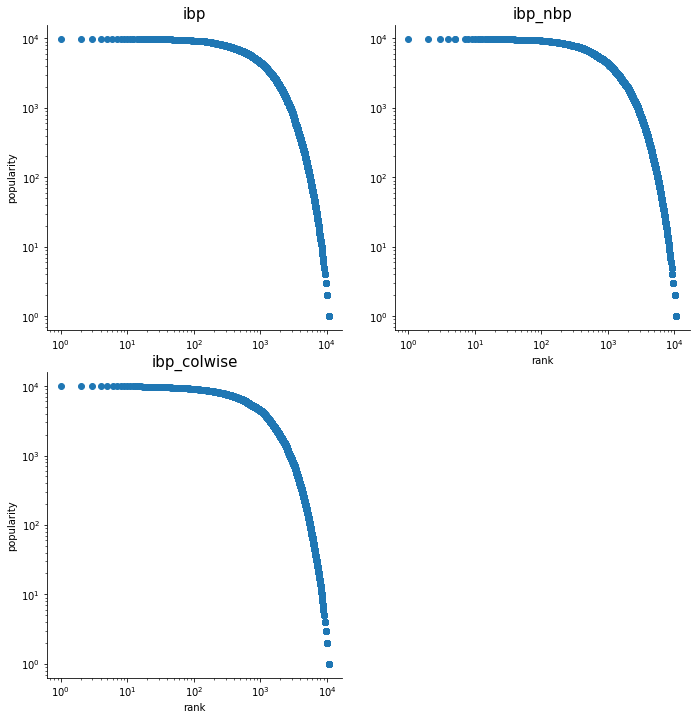

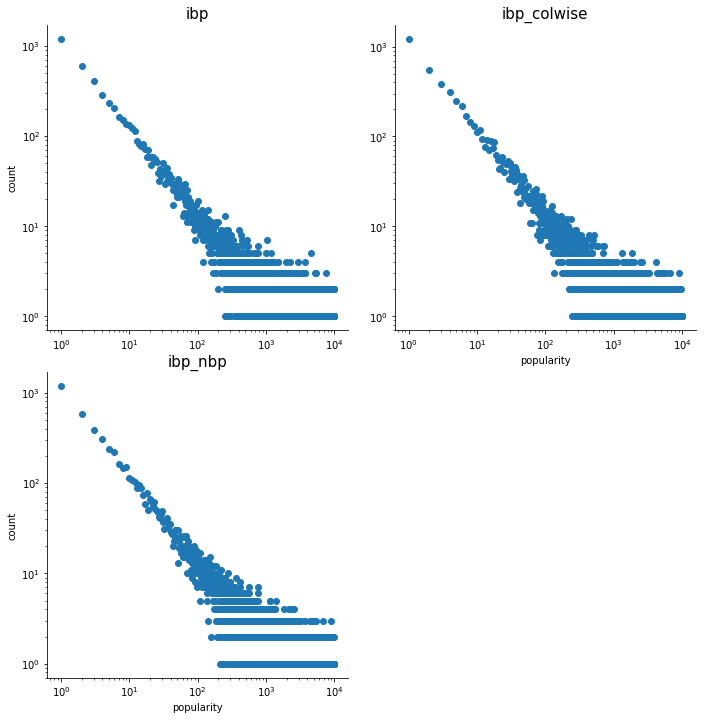

In [15]:
summarize_data_sets((('ibp', ibp), ('ibp_nbp', ibp_nbp), ('ibp_colwise', ibp_colwise)))

In [4]:
def draw_dist(dist_func, size=10000, **kwargs):
    data = dist_func(size=size, **kwargs)
    plt.figure(figsize=(8, 8))
    sns.distplot(data, kde=False)

### Geometric distribution

In [2]:
p = 0.1
size = 10000
data = np.random.geometric(p, size)

In [3]:
data.shape

(10000,)

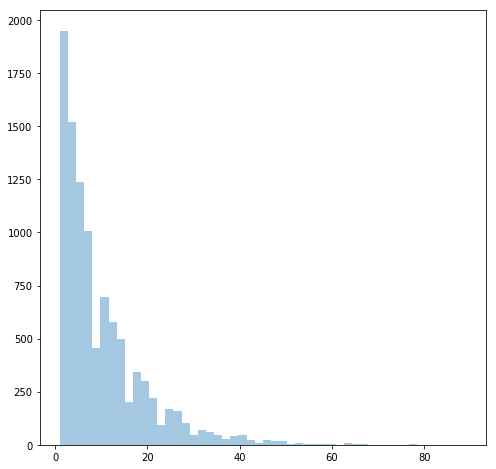

In [5]:
plt.figure(figsize=(8, 8))
sns.distplot(data, kde=False)

In [6]:
np.min(data)

1

In [7]:
pd.DataFrame({'sample': data}).describe()

,sample
count,10000.000000
mean,9.990300
std,9.555749
min,1.000000
25%,3.000000
50%,7.000000
75%,14.000000
max,89.000000


### Pareto

In [9]:
import scipy
from scipy.stats import pareto

In [49]:
def truncated_pareto(b, loc=0, scale=1, size=1, random_state=None):
    pareto_rvs = pareto.rvs(b, loc, scale, size, random_state=random_state)
    return pareto_rvs.astype(np.int64)

/home/MucunTian/anaconda3/envs/eval-error/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


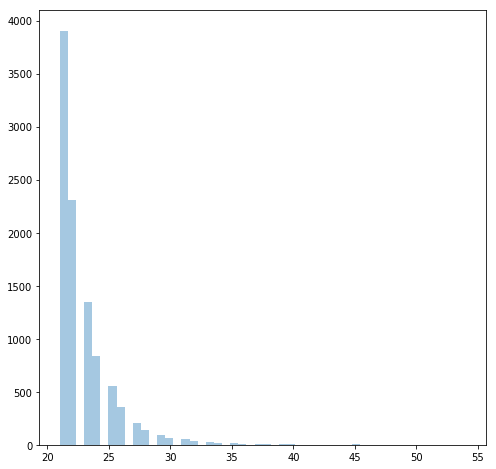

In [50]:
b = 10
loc = 1
scale = 20
draw_dist(truncated_pareto, b=b, loc=loc, scale=scale)

### Truncated poisson

In [22]:
def k_truncated_poisson(lam, k=20, size=None):
    rvs = np.random.poisson(lam, size)
    condition = rvs < k
    while any(condition):
        n = np.count_nonzero(condition)
        rvs[condition] = np.random.poisson(lam, n)
    return rvs

In [16]:
def zero_truncated_poisson(lam, size=None):
    k = np.ones(size)
    t = np.exp(-lam) / (1 - np.exp(-lam)) * lam
    s = t
    u = np.random.random(size)
    condition = s < u
    while any(condition):
        k[condition] = k[condition] + 1
        t = t * lam / k
        s = s + t
        condition = s < u
    return k

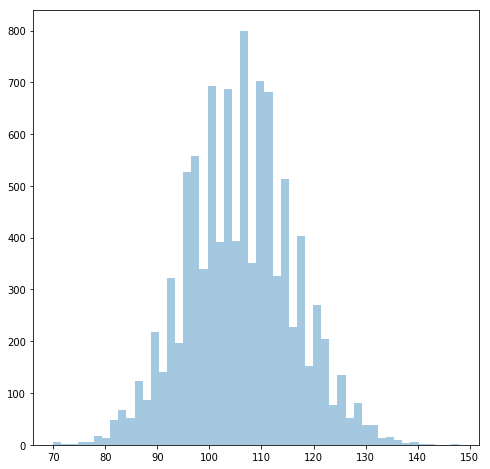

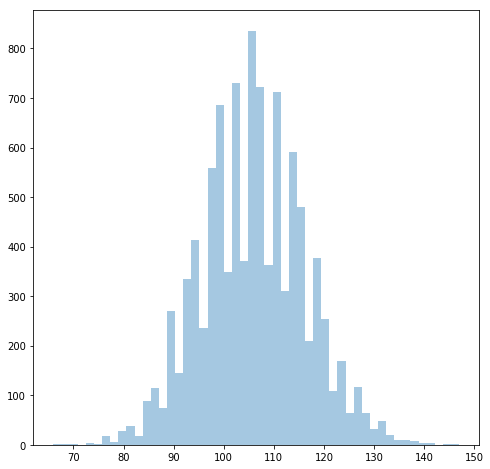

In [23]:
lam = 1000
draw_dist(zero_truncated_poisson, lam=106.0190)
draw_dist(k_truncated_poisson, lam=106.0190)

### Truncated geometric

In [40]:
def truncated_geometric(p, N, size=None):
    unif_rvs = np.random.random(size)
    return np.floor(np.log(1 - unif_rvs * (1 - (1 - p) ** N)) / np.log(1 - p))

/home/MucunTian/anaconda3/envs/eval-error/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


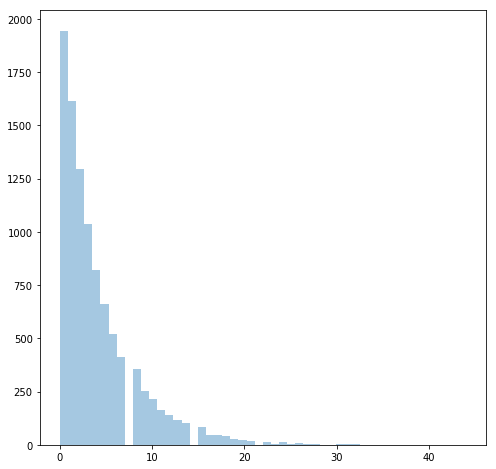

In [41]:
p = 0.2
N = 100
draw_dist(truncated_geometric, p=p, N=N)